In [2]:
from datasets import load_dataset

dataset = load_dataset("nexar-ai/nexar_collision_prediction", split="train")

print(dataset.cache_files)
print(dataset.column_names)
print(len(dataset))

train_valid = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_valid['train']
valid_dataset = train_valid['test']
print("train length:", len(train_dataset))
print("valid length:", len(valid_dataset))

c:\Users\USER\miniconda3\envs\accident_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'filename': 'C:\\Users\\USER\\.cache\\huggingface\\datasets\\nexar-ai___nexar_collision_prediction\\default\\0.0.0\\aa97deda5a59f00bb7187739053b7c72e14374df\\nexar_collision_prediction-train.arrow'}]
['video', 'time_of_event', 'time_of_alert', 'light_conditions', 'weather', 'scene', 'time_to_accident']
1500
train length: 1200
valid length: 300


In [4]:
test_dataset  = load_dataset("nexar-ai/nexar_collision_prediction", split="test")
print(len(test_dataset))

Using the latest cached version of the dataset since nexar-ai/nexar_collision_prediction couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\USER\.cache\huggingface\datasets\nexar-ai___nexar_collision_prediction\default\0.0.0\aa97deda5a59f00bb7187739053b7c72e14374df (last modified on Mon Oct 13 12:29:49 2025).


1344


In [17]:
import os
import pandas as pd

base_dir = r"C:\\Users\\USER\\.cache\\huggingface\\hub\datasets--nexar-ai--nexar_collision_prediction\\snapshots\\aa97deda5a59f00bb7187739053b7c72e14374df\\train"

pos_dir = os.path.join(base_dir, "positive")
neg_dir = os.path.join(base_dir, "negative")

pos_meta = pd.read_csv(os.path.join(pos_dir, "metadata.csv"))
neg_meta = pd.read_csv(os.path.join(neg_dir, "metadata.csv"))

pos_meta["label"] = 1
neg_meta["label"] = 0

In [ ]:
meta = pd.concat([pos_meta.assign(folder=pos_dir), neg_meta.assign(folder=neg_dir)], ignore_index=True)

print("Total videos:", len(meta))
meta.head()

Total videos: 1500


file_name  time_of_event  time_of_alert light_conditions weather  \
0  00822.mp4         19.500         18.633           Normal  Cloudy   
1  00208.mp4         19.800         19.233           Normal  Cloudy   
2  00072.mp4         20.101         20.068           Normal   Clear   
3  00128.mp4         19.267         18.333           Normal   Clear   
4  00205.mp4         21.146         18.196           Normal   Clear   

       scene  time_to_accident  label  \
0      Urban               NaN      1   
1  Sub-urban               NaN      1   
2      Urban               NaN      1   
3      Urban               NaN      1   
4    Highway               NaN      1   

                                              folder  
0  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
1  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
2  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
3  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
4  C:\\Users\\USER\\.cache\\huggingface\\hub\data...

In [41]:
import cv2
import numpy as np

def video_batch_generator(meta_df, batch_size=8, num_frames=16, seconds_before=5, seconds_after=5, target_size=(224, 224)):
    n = len(meta_df)
    for start_idx in range(0, n, batch_size):
        batch_meta = meta_df.iloc[start_idx : start_idx + batch_size]
        batch_videos = []
        batch_labels = []
        batch_metadata = []
        skipped_video_counter=0

        for _, row in batch_meta.iterrows():
            video_path = os.path.join(row["folder"], row["file_name"])
            label = row["label"]
            time_of_event = row["time_of_event"]

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Skipping unreadable video: {video_path}")
                skipped_video_counter+=1
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = n_frames / fps

            if time_of_event is not None and not np.isnan(time_of_event):
                if (time_of_event - seconds_before) < 0:
                    start_time = 0
                else:
                    start_time = time_of_event - seconds_before

                if (time_of_event + seconds_after) > duration:
                    end_time = duration
                else:
                    end_time = time_of_event + seconds_after

            else:
                # if no accident
                start_time = 0
                end_time = duration


            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            selected_frames = np.linspace(start_frame, end_frame - 1, num_frames, dtype=int)

            frames = []
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            current_idx = start_frame
            flag, frame = cap.read()

            while flag and current_idx <= end_frame:
                if current_idx in selected_frames:
                    frame = cv2.resize(frame, target_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
                    if len(frames) == num_frames:
                        break
                flag, frame = cap.read()
                current_idx += 1

            cap.release()

            if len(frames) != num_frames:
                print(f"Skipping {video_path} (got only {len(frames)} frames)")
                continue

            # max_frames = int((seconds_before + seconds_after) * fps)
            # frames = np.array(frames, dtype=np.float32) / 255.0
            # if len(frames) < max_frames:
            #     pad = np.zeros((max_frames - len(frames), *frames.shape[1:]), dtype=np.float32)
            #     frames = np.concatenate([frames, pad], axis=0)

            batch_videos.append(np.array(frames))
            batch_labels.append(label)
            batch_metadata.append(row.to_dict())

        if batch_videos:
            yield np.array(batch_videos), np.array(batch_labels), batch_metadata

In [44]:
train_gen = video_batch_generator(meta, batch_size=8)

total_videos = 0
for X_batch, y_batch, batch_metadata in train_gen:
    if len(X_batch) == 0:
        continue
    
    print("Batch size:", len(X_batch))
    total_videos += len(X_batch)

    if total_videos >= len(meta):
        break

print("Total videos processed:", total_videos)
print("Expected videos:", len(meta))

Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch size: 8
Batch 

Metadata for this batch:


file_name  time_of_event  time_of_alert light_conditions weather  \
0  00822.mp4         19.500         18.633           Normal  Cloudy   
1  00208.mp4         19.800         19.233           Normal  Cloudy   
2  00072.mp4         20.101         20.068           Normal   Clear   
3  00128.mp4         19.267         18.333           Normal   Clear   
4  00205.mp4         21.146         18.196           Normal   Clear   
5  00408.mp4         19.953         17.551           Normal   Clear   
6  00948.mp4         20.287         19.219           Normal   Clear   
7  00457.mp4         19.600         19.367           Normal  Cloudy   

       scene  time_to_accident  label  \
0      Urban               NaN      1   
1  Sub-urban               NaN      1   
2      Urban               NaN      1   
3      Urban               NaN      1   
4    Highway               NaN      1   
5      Urban               NaN      1   
6  Sub-urban               NaN      1   
7  Sub-urban               NaN      1   

                                              folder  
0  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
1  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
2  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
3  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
4  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
5  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
6  C:\\Users\\USER\\.cache\\huggingface\\hub\data...  
7  C:\\Users\\USER\\.cache\\huggingface\\hub\data...


🎥 Video 1 — Label: 1 — File: 00822.mp4
{'file_name': '00822.mp4', 'time_of_event': 19.5, 'time_of_alert': 18.633, 'light_conditions': 'Normal', 'weather': 'Cloudy', 'scene': 'Urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


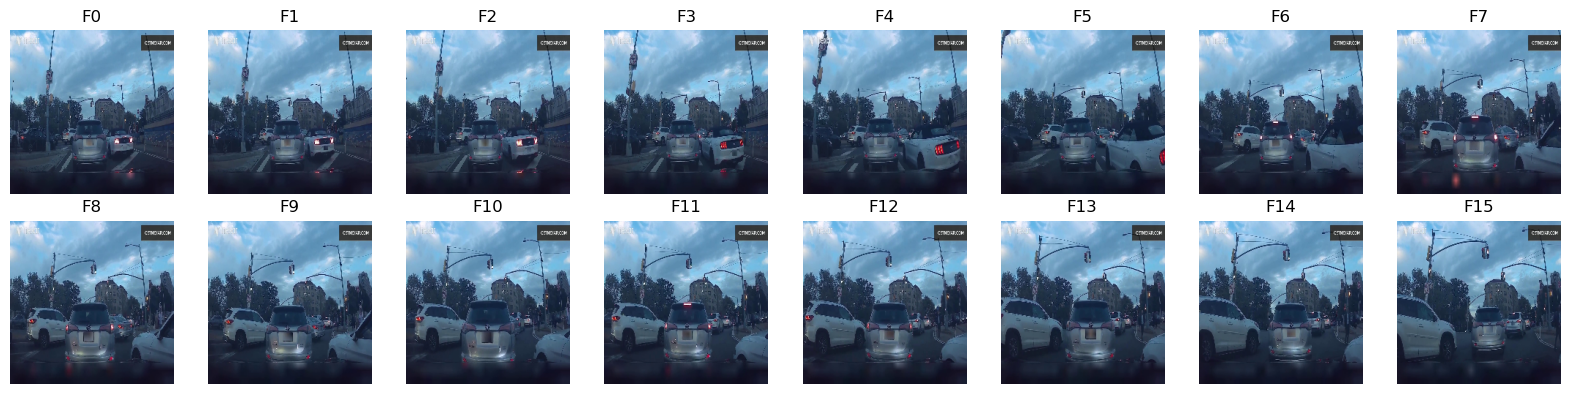


🎥 Video 2 — Label: 1 — File: 00208.mp4
{'file_name': '00208.mp4', 'time_of_event': 19.8, 'time_of_alert': 19.233, 'light_conditions': 'Normal', 'weather': 'Cloudy', 'scene': 'Sub-urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


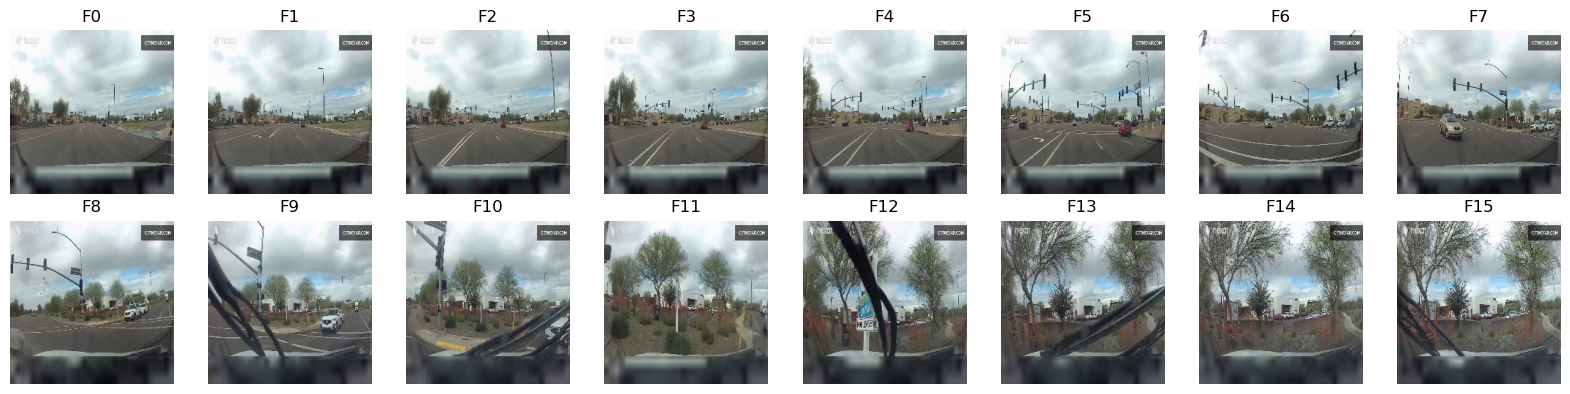


🎥 Video 3 — Label: 1 — File: 00072.mp4
{'file_name': '00072.mp4', 'time_of_event': 20.101, 'time_of_alert': 20.068, 'light_conditions': 'Normal', 'weather': 'Clear', 'scene': 'Urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


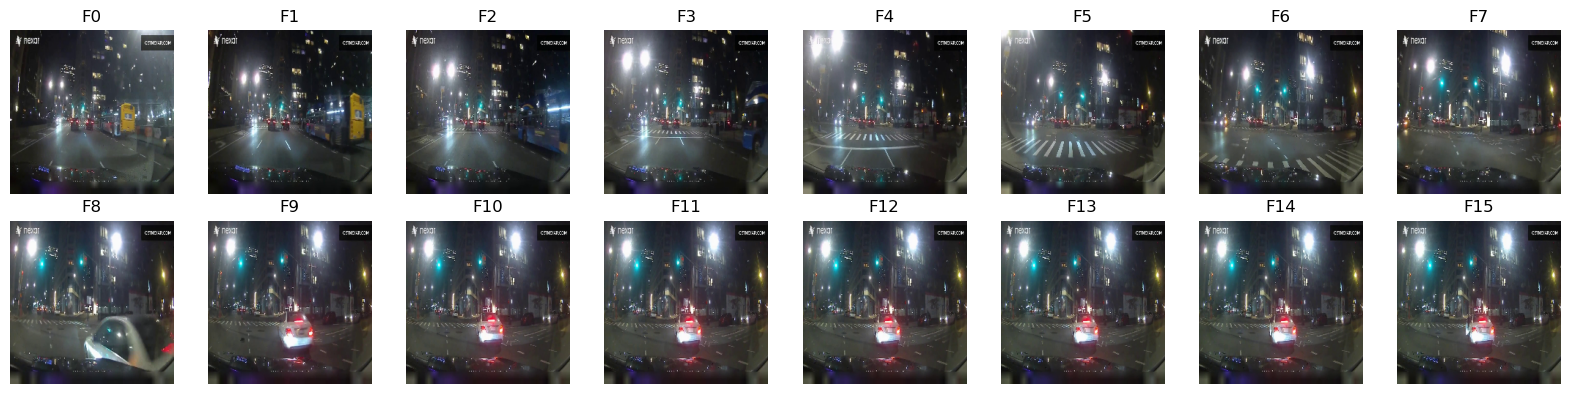


🎥 Video 4 — Label: 1 — File: 00128.mp4
{'file_name': '00128.mp4', 'time_of_event': 19.267, 'time_of_alert': 18.333, 'light_conditions': 'Normal', 'weather': 'Clear', 'scene': 'Urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


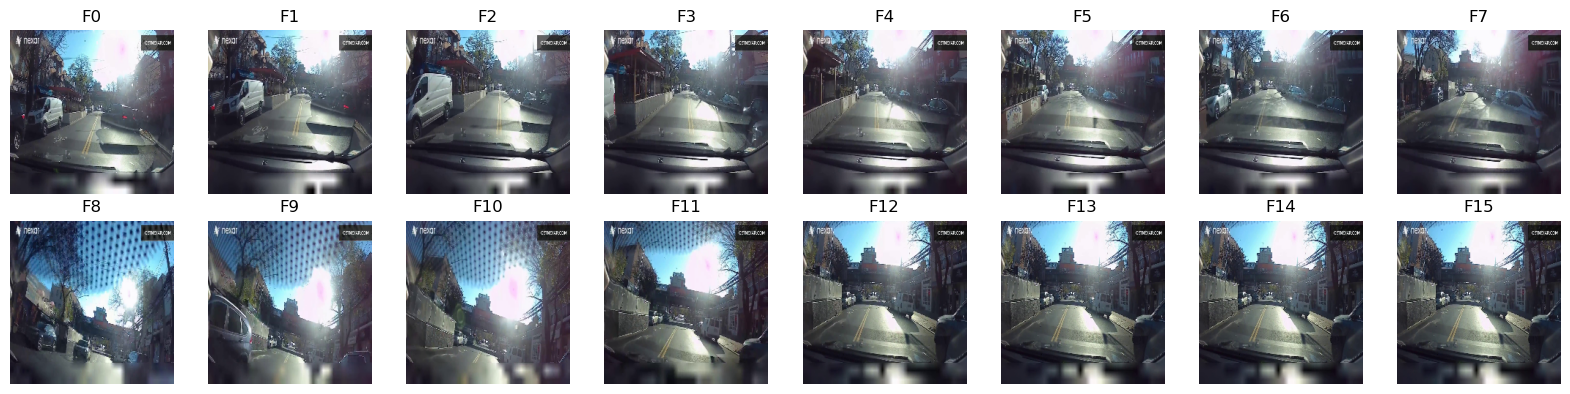


🎥 Video 5 — Label: 1 — File: 00205.mp4
{'file_name': '00205.mp4', 'time_of_event': 21.146, 'time_of_alert': 18.196, 'light_conditions': 'Normal', 'weather': 'Clear', 'scene': 'Highway', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


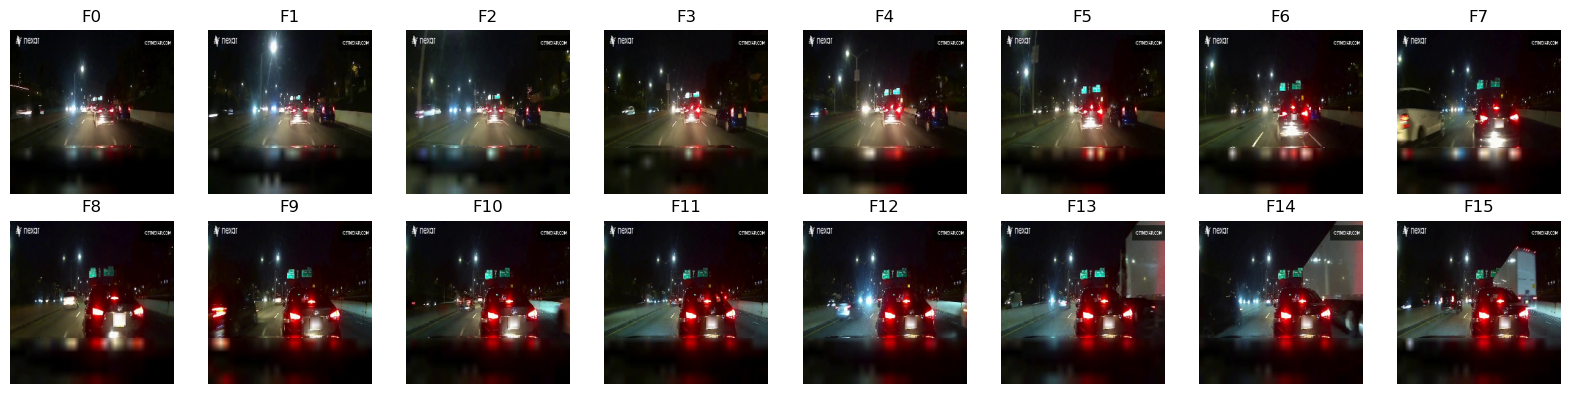


🎥 Video 6 — Label: 1 — File: 00408.mp4
{'file_name': '00408.mp4', 'time_of_event': 19.953, 'time_of_alert': 17.551, 'light_conditions': 'Normal', 'weather': 'Clear', 'scene': 'Urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


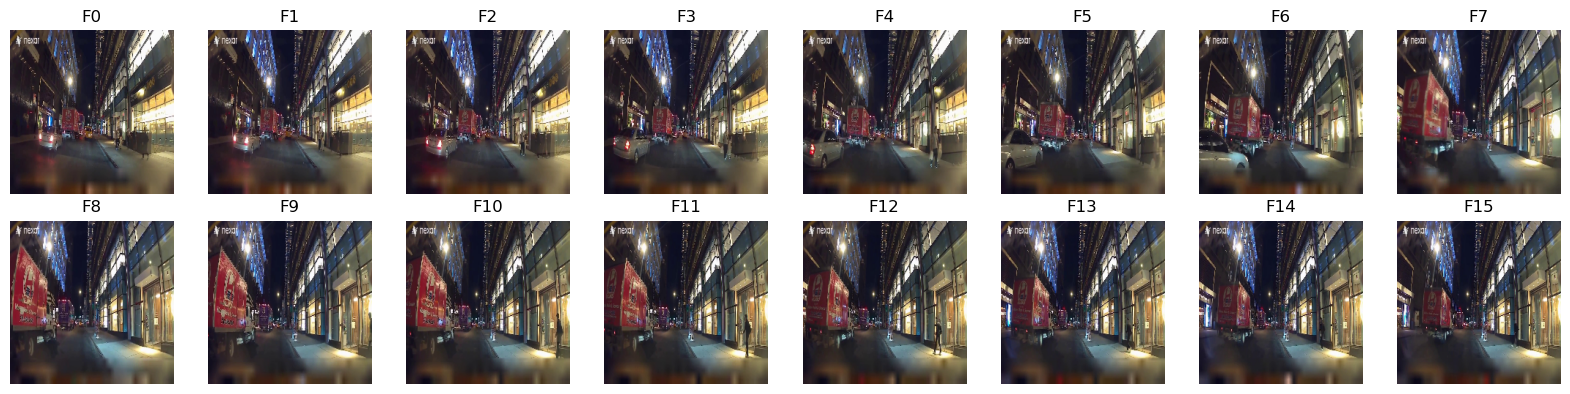


🎥 Video 7 — Label: 1 — File: 00948.mp4
{'file_name': '00948.mp4', 'time_of_event': 20.287, 'time_of_alert': 19.219, 'light_conditions': 'Normal', 'weather': 'Clear', 'scene': 'Sub-urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


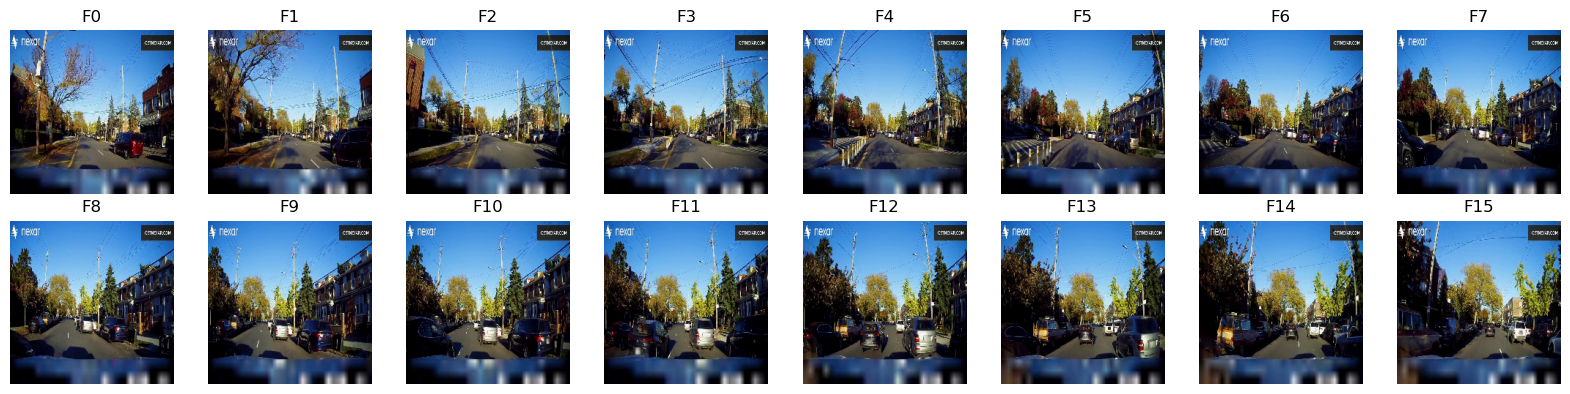


🎥 Video 8 — Label: 1 — File: 00457.mp4
{'file_name': '00457.mp4', 'time_of_event': 19.6, 'time_of_alert': 19.367, 'light_conditions': 'Normal', 'weather': 'Cloudy', 'scene': 'Sub-urban', 'time_to_accident': nan, 'label': 1, 'folder': 'C:\\\\Users\\\\USER\\\\.cache\\\\huggingface\\\\hub\\datasets--nexar-ai--nexar_collision_prediction\\\\snapshots\\\\aa97deda5a59f00bb7187739053b7c72e14374df\\\\train\\positive'}


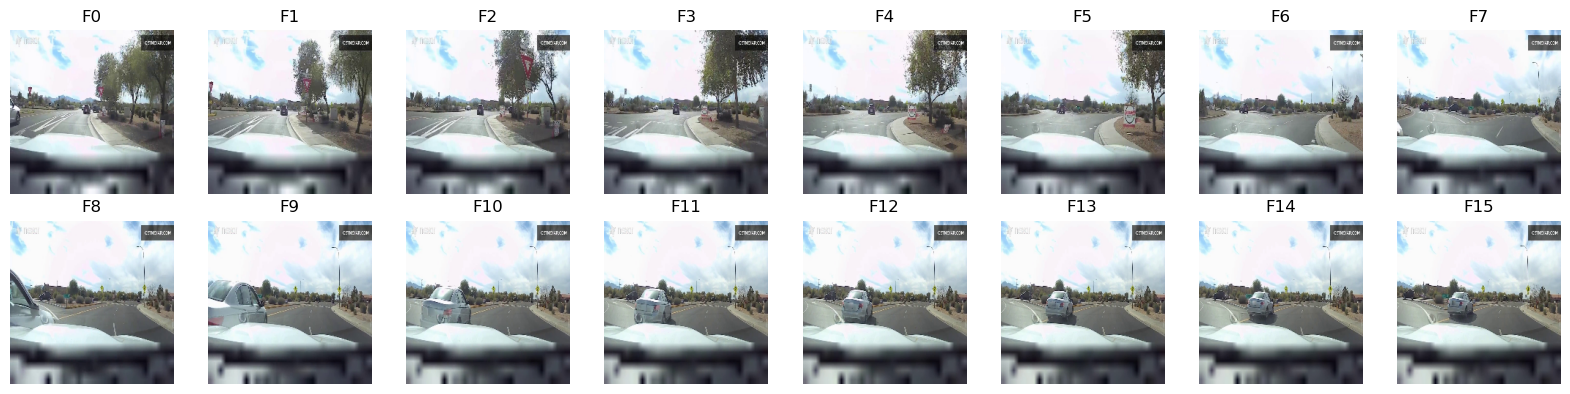

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Take one batch from the generator
train_gen = video_batch_generator(meta, batch_size=8)
X_batch, y_batch, batch_metadata = next(train_gen)

# Convert metadata list of dicts → DataFrame
meta_df_batch = pd.DataFrame(batch_metadata)
meta_df_batch["label"] = y_batch

# Display the DataFrame (metadata table)
print("Metadata for this batch:")
display(meta_df_batch)

# Show all videos (16 frames each)
for i in range(len(X_batch)):
    video = X_batch[i]
    meta_row = meta_df_batch.iloc[i]

    print(f"\n🎥 Video {i+1} — Label: {meta_row['label']} — File: {meta_row['file_name']}")
    print(meta_row.to_dict())  # show all metadata for this video

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    axes = axes.flatten()
    for j in range(min(16, len(video))):
        axes[j].imshow(video[j].astype(np.uint8))
        axes[j].axis("off")
        axes[j].set_title(f"F{j}")
    plt.tight_layout()
    plt.show()